**GW25_PFCVZ_SVZ**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/GW25_05_20240216_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [4]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/GW25_PFCVZ_SVZ/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-GW25_PFCVZ_SVZ-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 8888 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


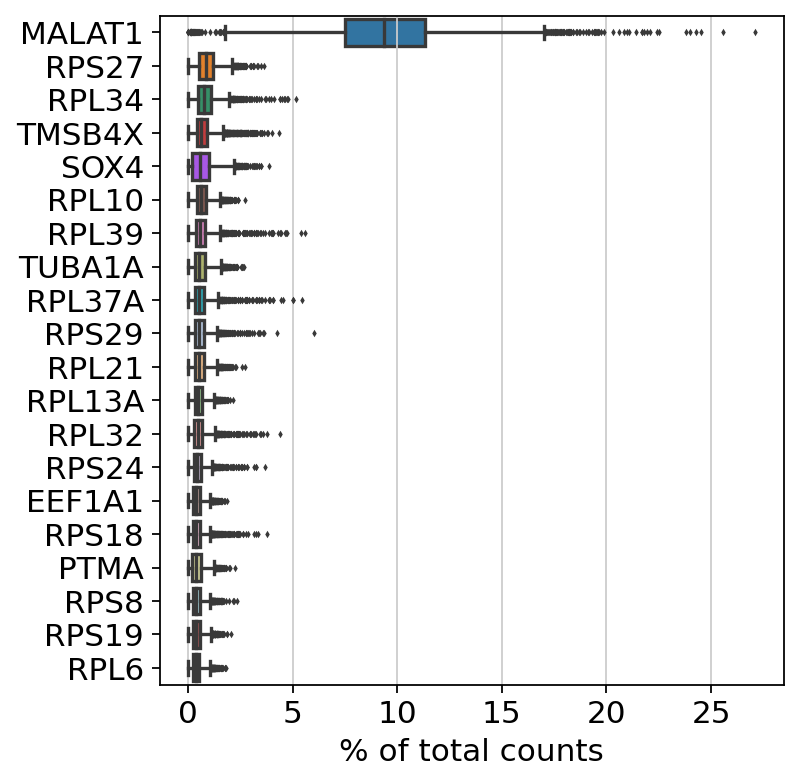

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 22761 genes that are detected in less than 50 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

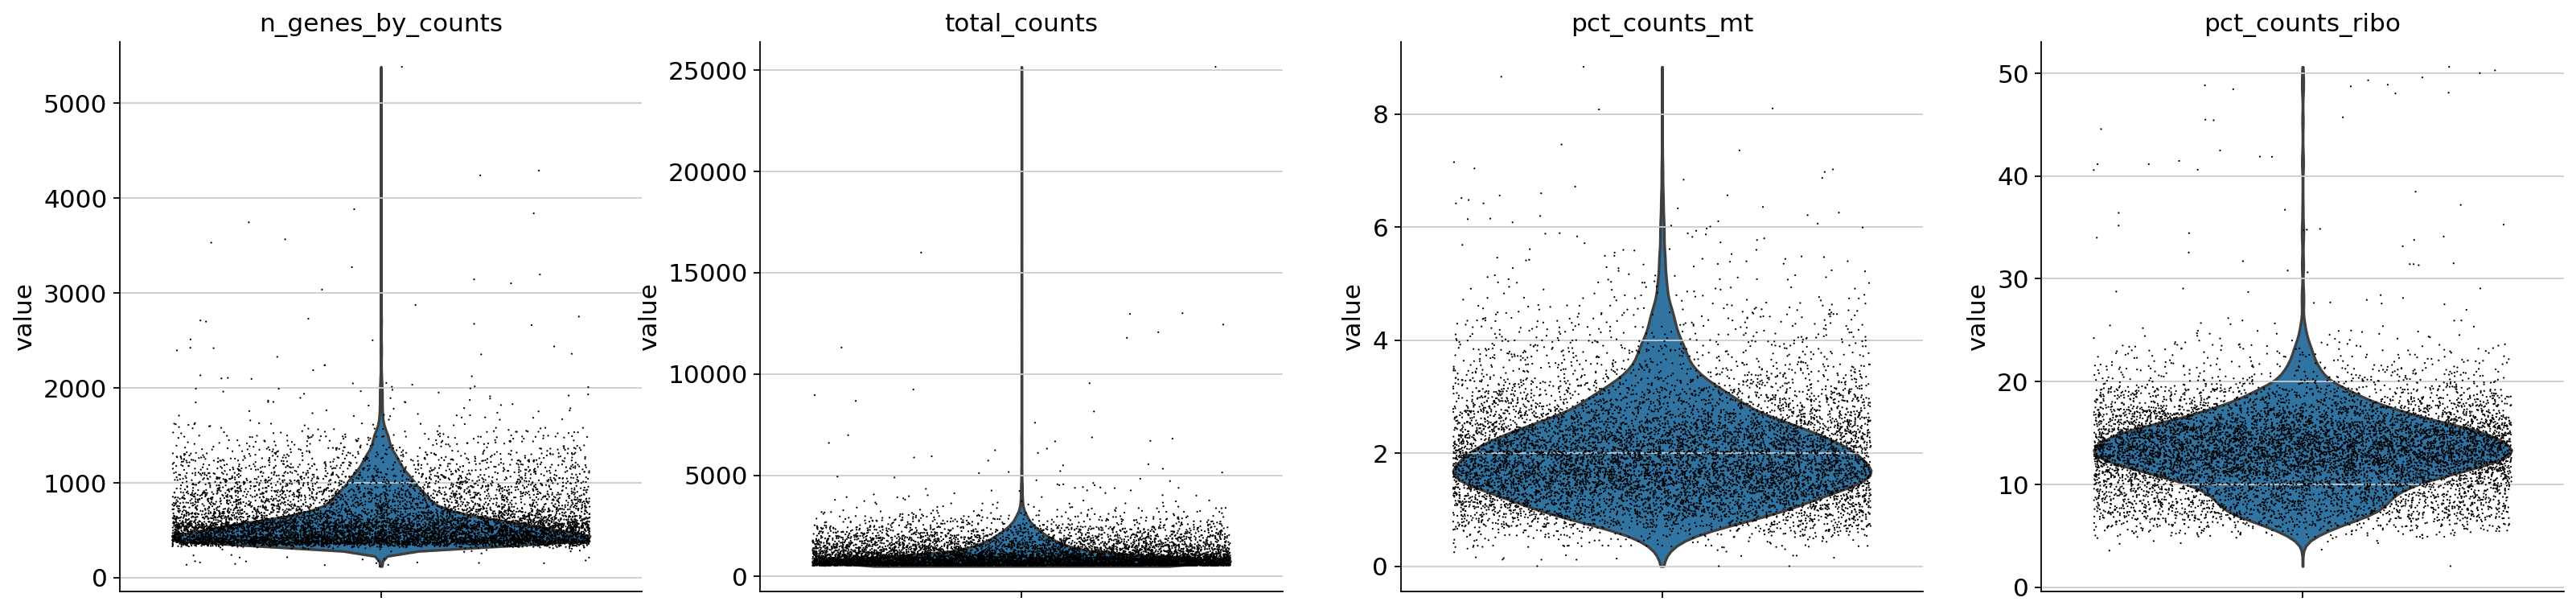

In [11]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

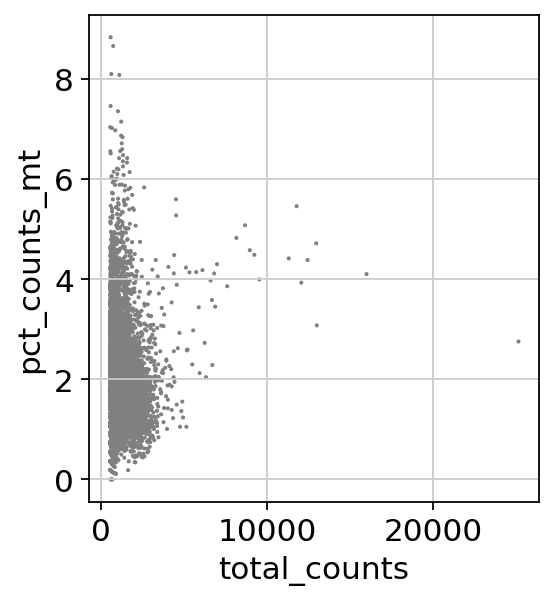

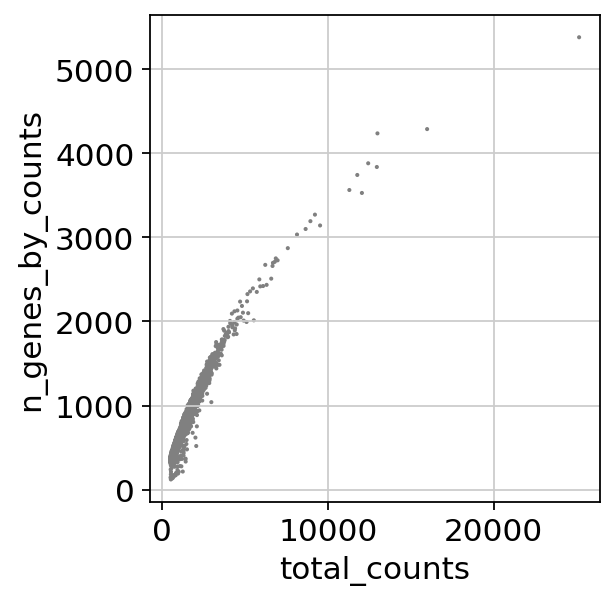

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.total_counts <= 5000]

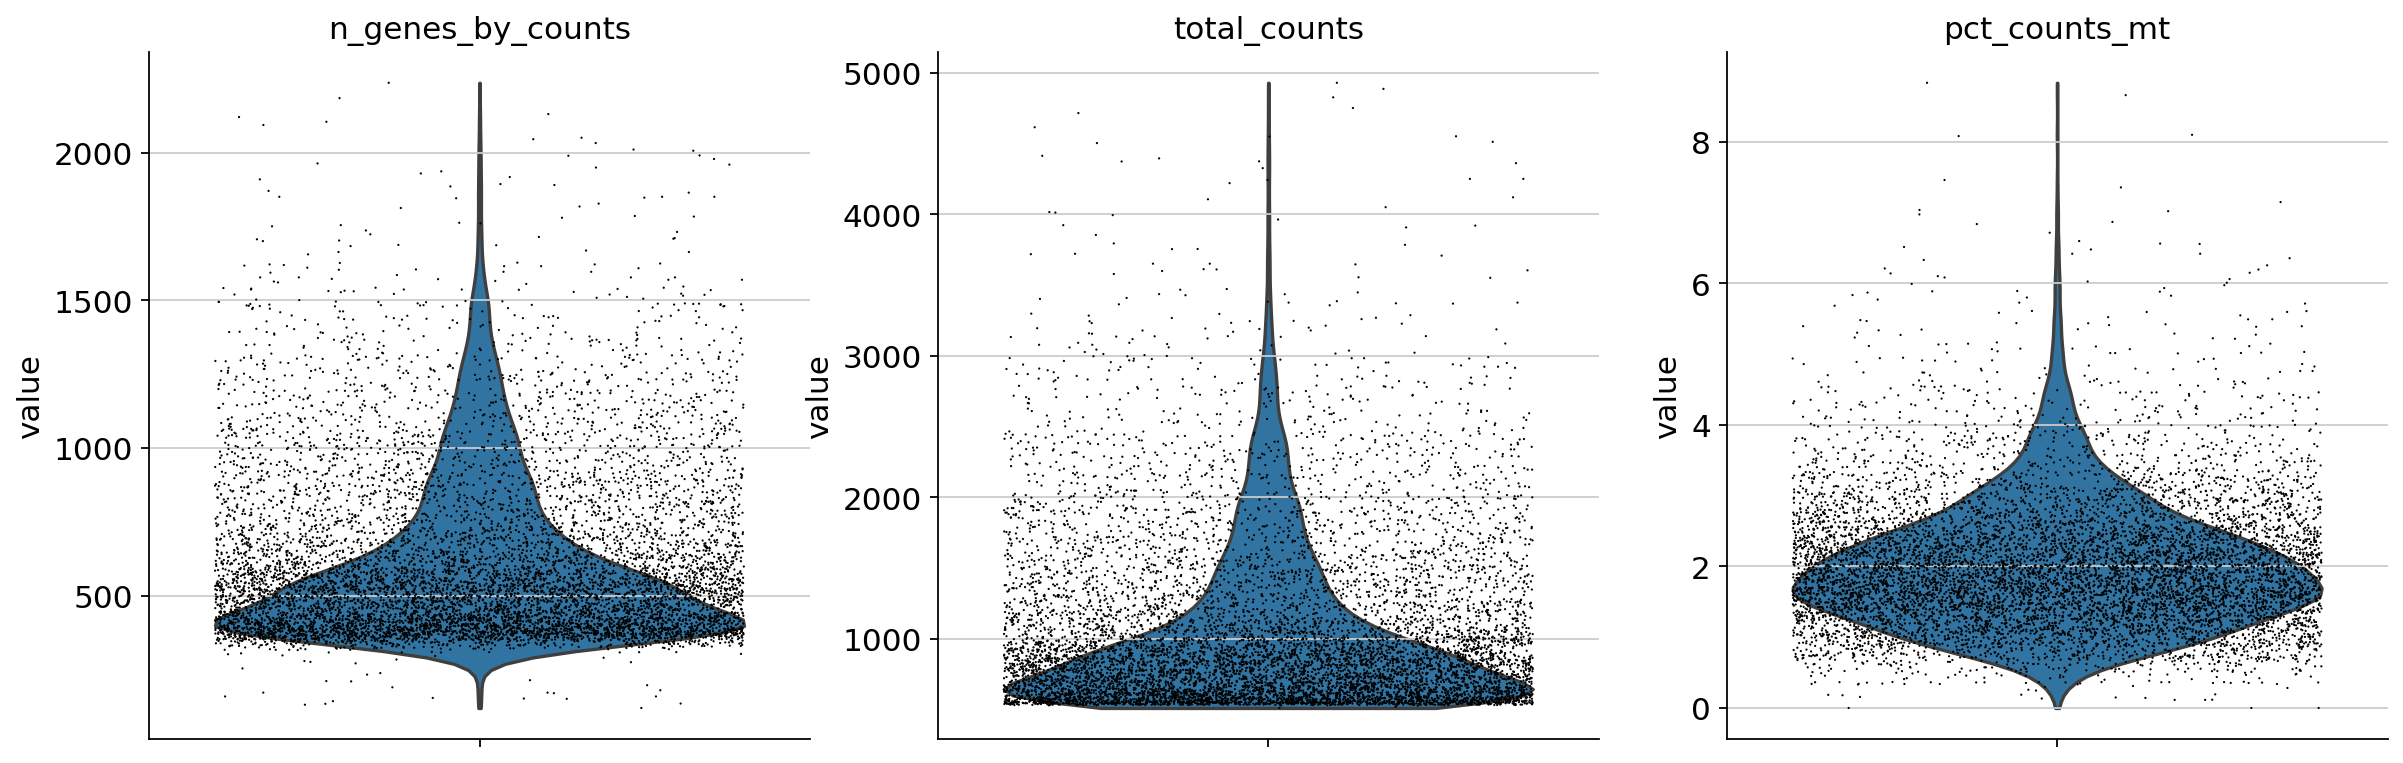

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [15]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'


Trying to set attribute `.obs` of view, copying.


    finished: added
    'S_score', score of gene set (adata.obs).
    942 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    856 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [16]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [17]:
adata.obs.phase.value_counts()

G1     4947
S      3120
G2M     788
Name: phase, dtype: int64

In [18]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%
    Scrublet finished (0:00:07)


In [19]:
adata.obs.predicted_doublet.value_counts()

False    8855
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=5000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 8855 × 10933
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:34)


Index(['ARHGAP29', 'COL4A1', 'HIGD1B', 'TREM2', 'FRZB', 'C1QC', 'PRKCDBP',
       'CD14', 'FOLR2', 'ITIH5', 'SRGN', 'BCAS1', 'CCL3L3', 'VSIG4', 'FCER1G',
       'NDUFA4L2', 'C1QB', 'GPNMB', 'TYROBP', 'COL4A2'],
      dtype='object')

In [23]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['HES4', 'ISG15', 'AGRN', 'VWA1', 'HES5', 'FBXO2', 'KAZN', 'NBL1',
       'ECE1', 'C1QA',
       ...
       'SAMSN1', 'GRIK1', 'OLIG2', 'OLIG1', 'ETS2', 'PCP4', 'RSPH1', 'ITGB2',
       'C21orf58', 'S100B'],
      dtype='object', length=817)

# Principle Component Analysis

In [24]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'phase' as categorical


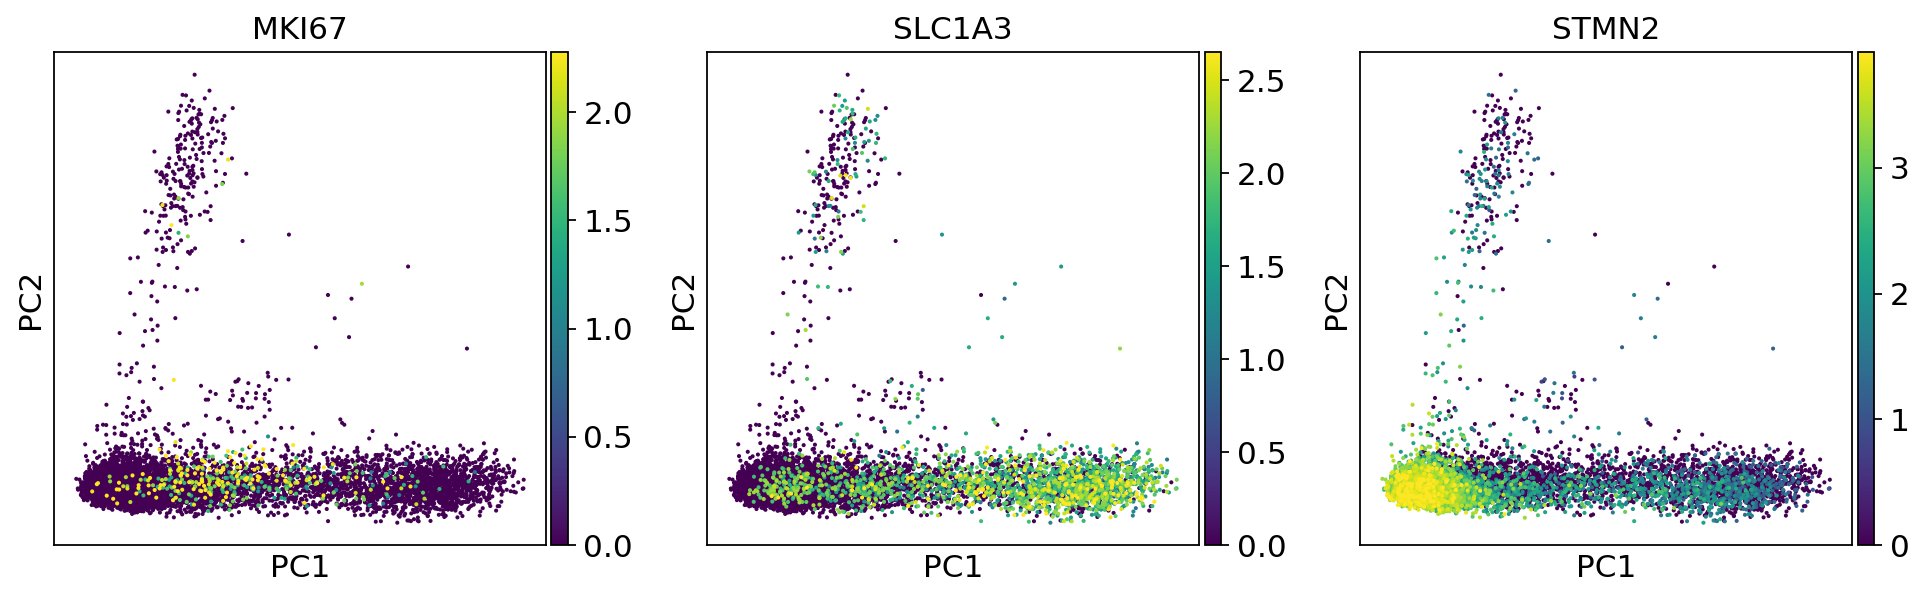

In [25]:
# We can make a scatter plot in the PCA coordinates, but we will not use that later on.

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") 

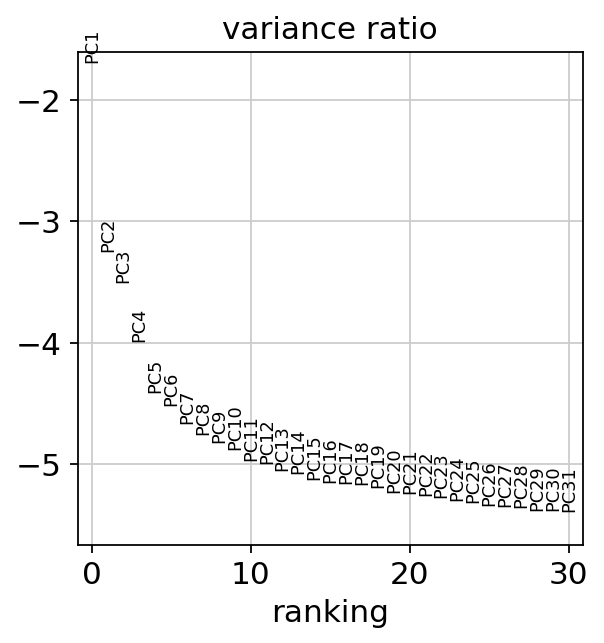

In [26]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
# saving the result
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 8855 × 10933
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [29]:
int(0.5 * len(adata) ** 0.5)

47

In [30]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


# Embedding Neighborhood Graph

In [31]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [32]:
adata.obs.leiden.value_counts()

0     1878
1     1275
2      938
3      777
4      775
5      756
6      622
7      588
8      460
9      276
10     248
11     215
12      47
Name: leiden, dtype: int64

In [33]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


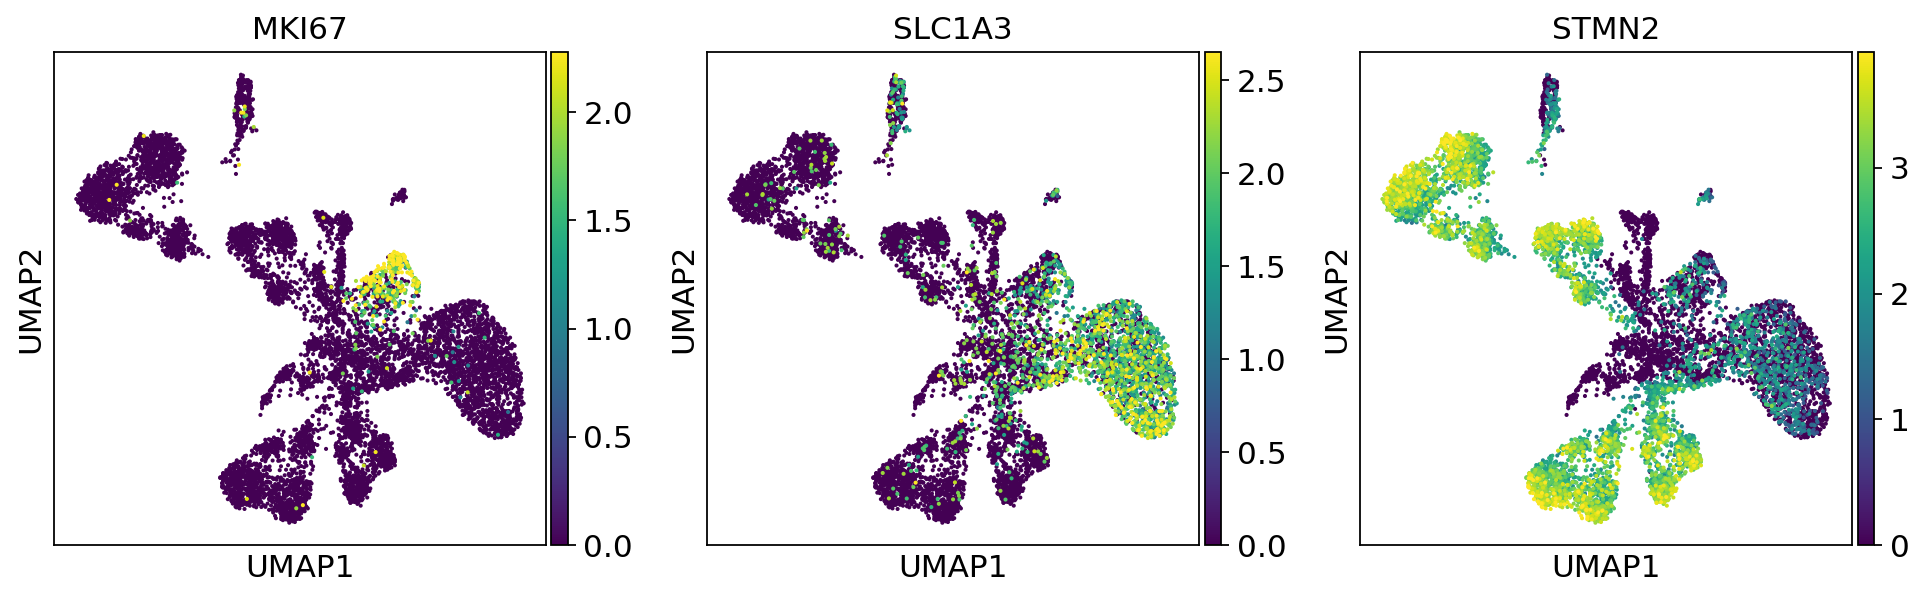

In [35]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

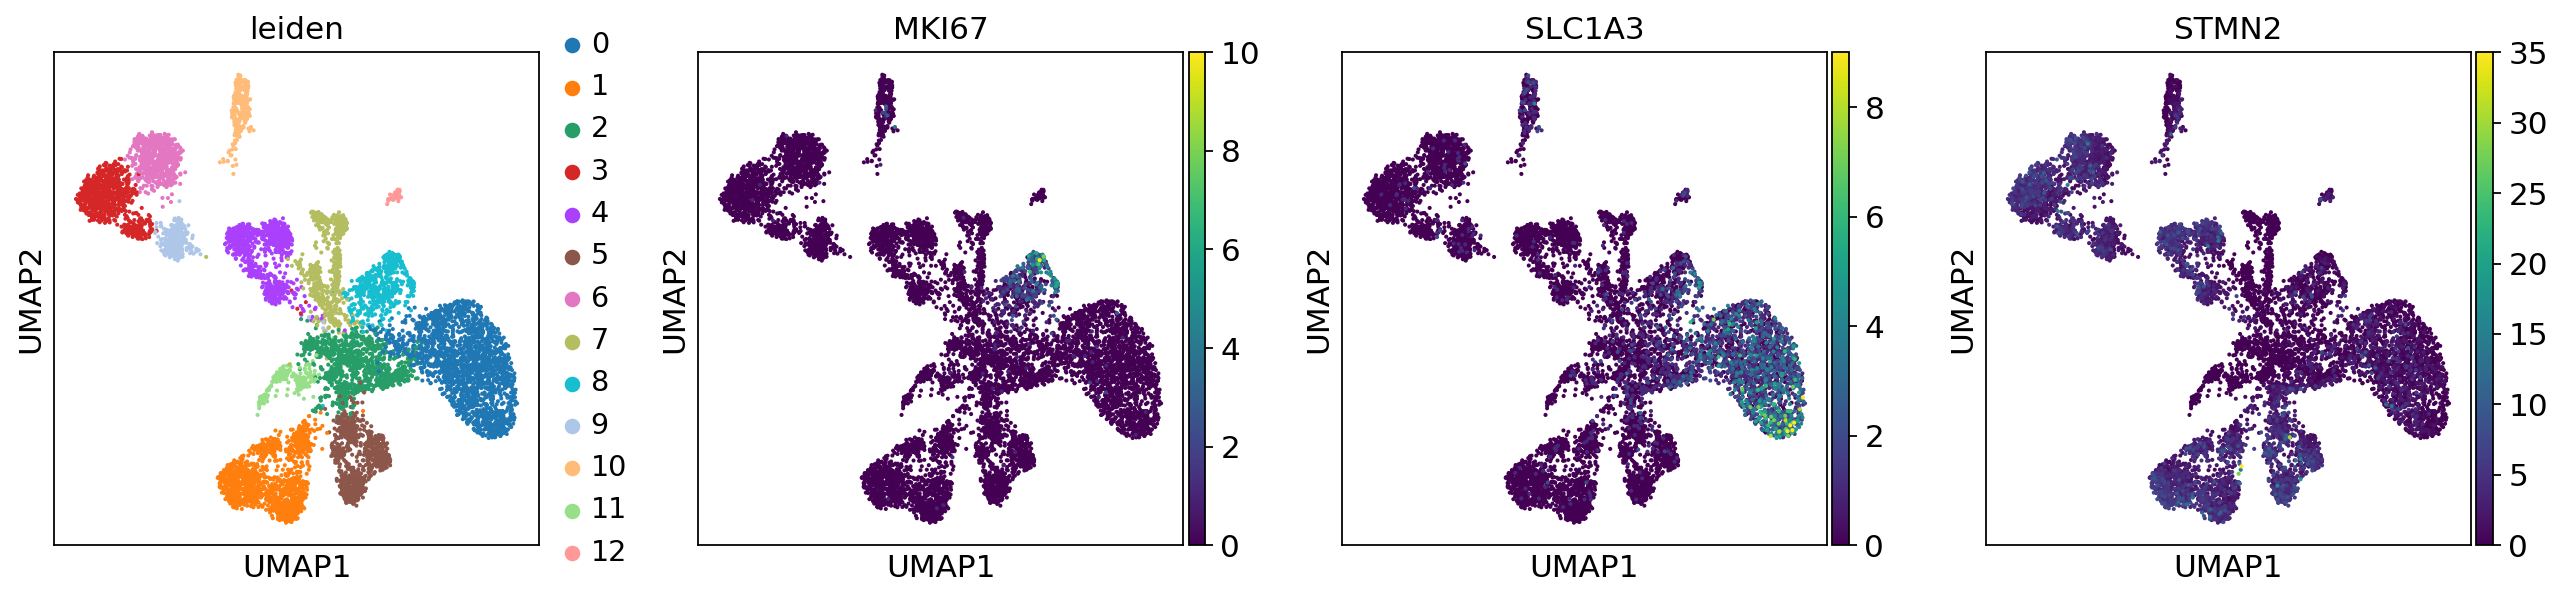

In [36]:
sc.pl.umap(adata, color=['leiden', 'MKI67','SLC1A3','STMN2'])

In [37]:
# saving results
adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


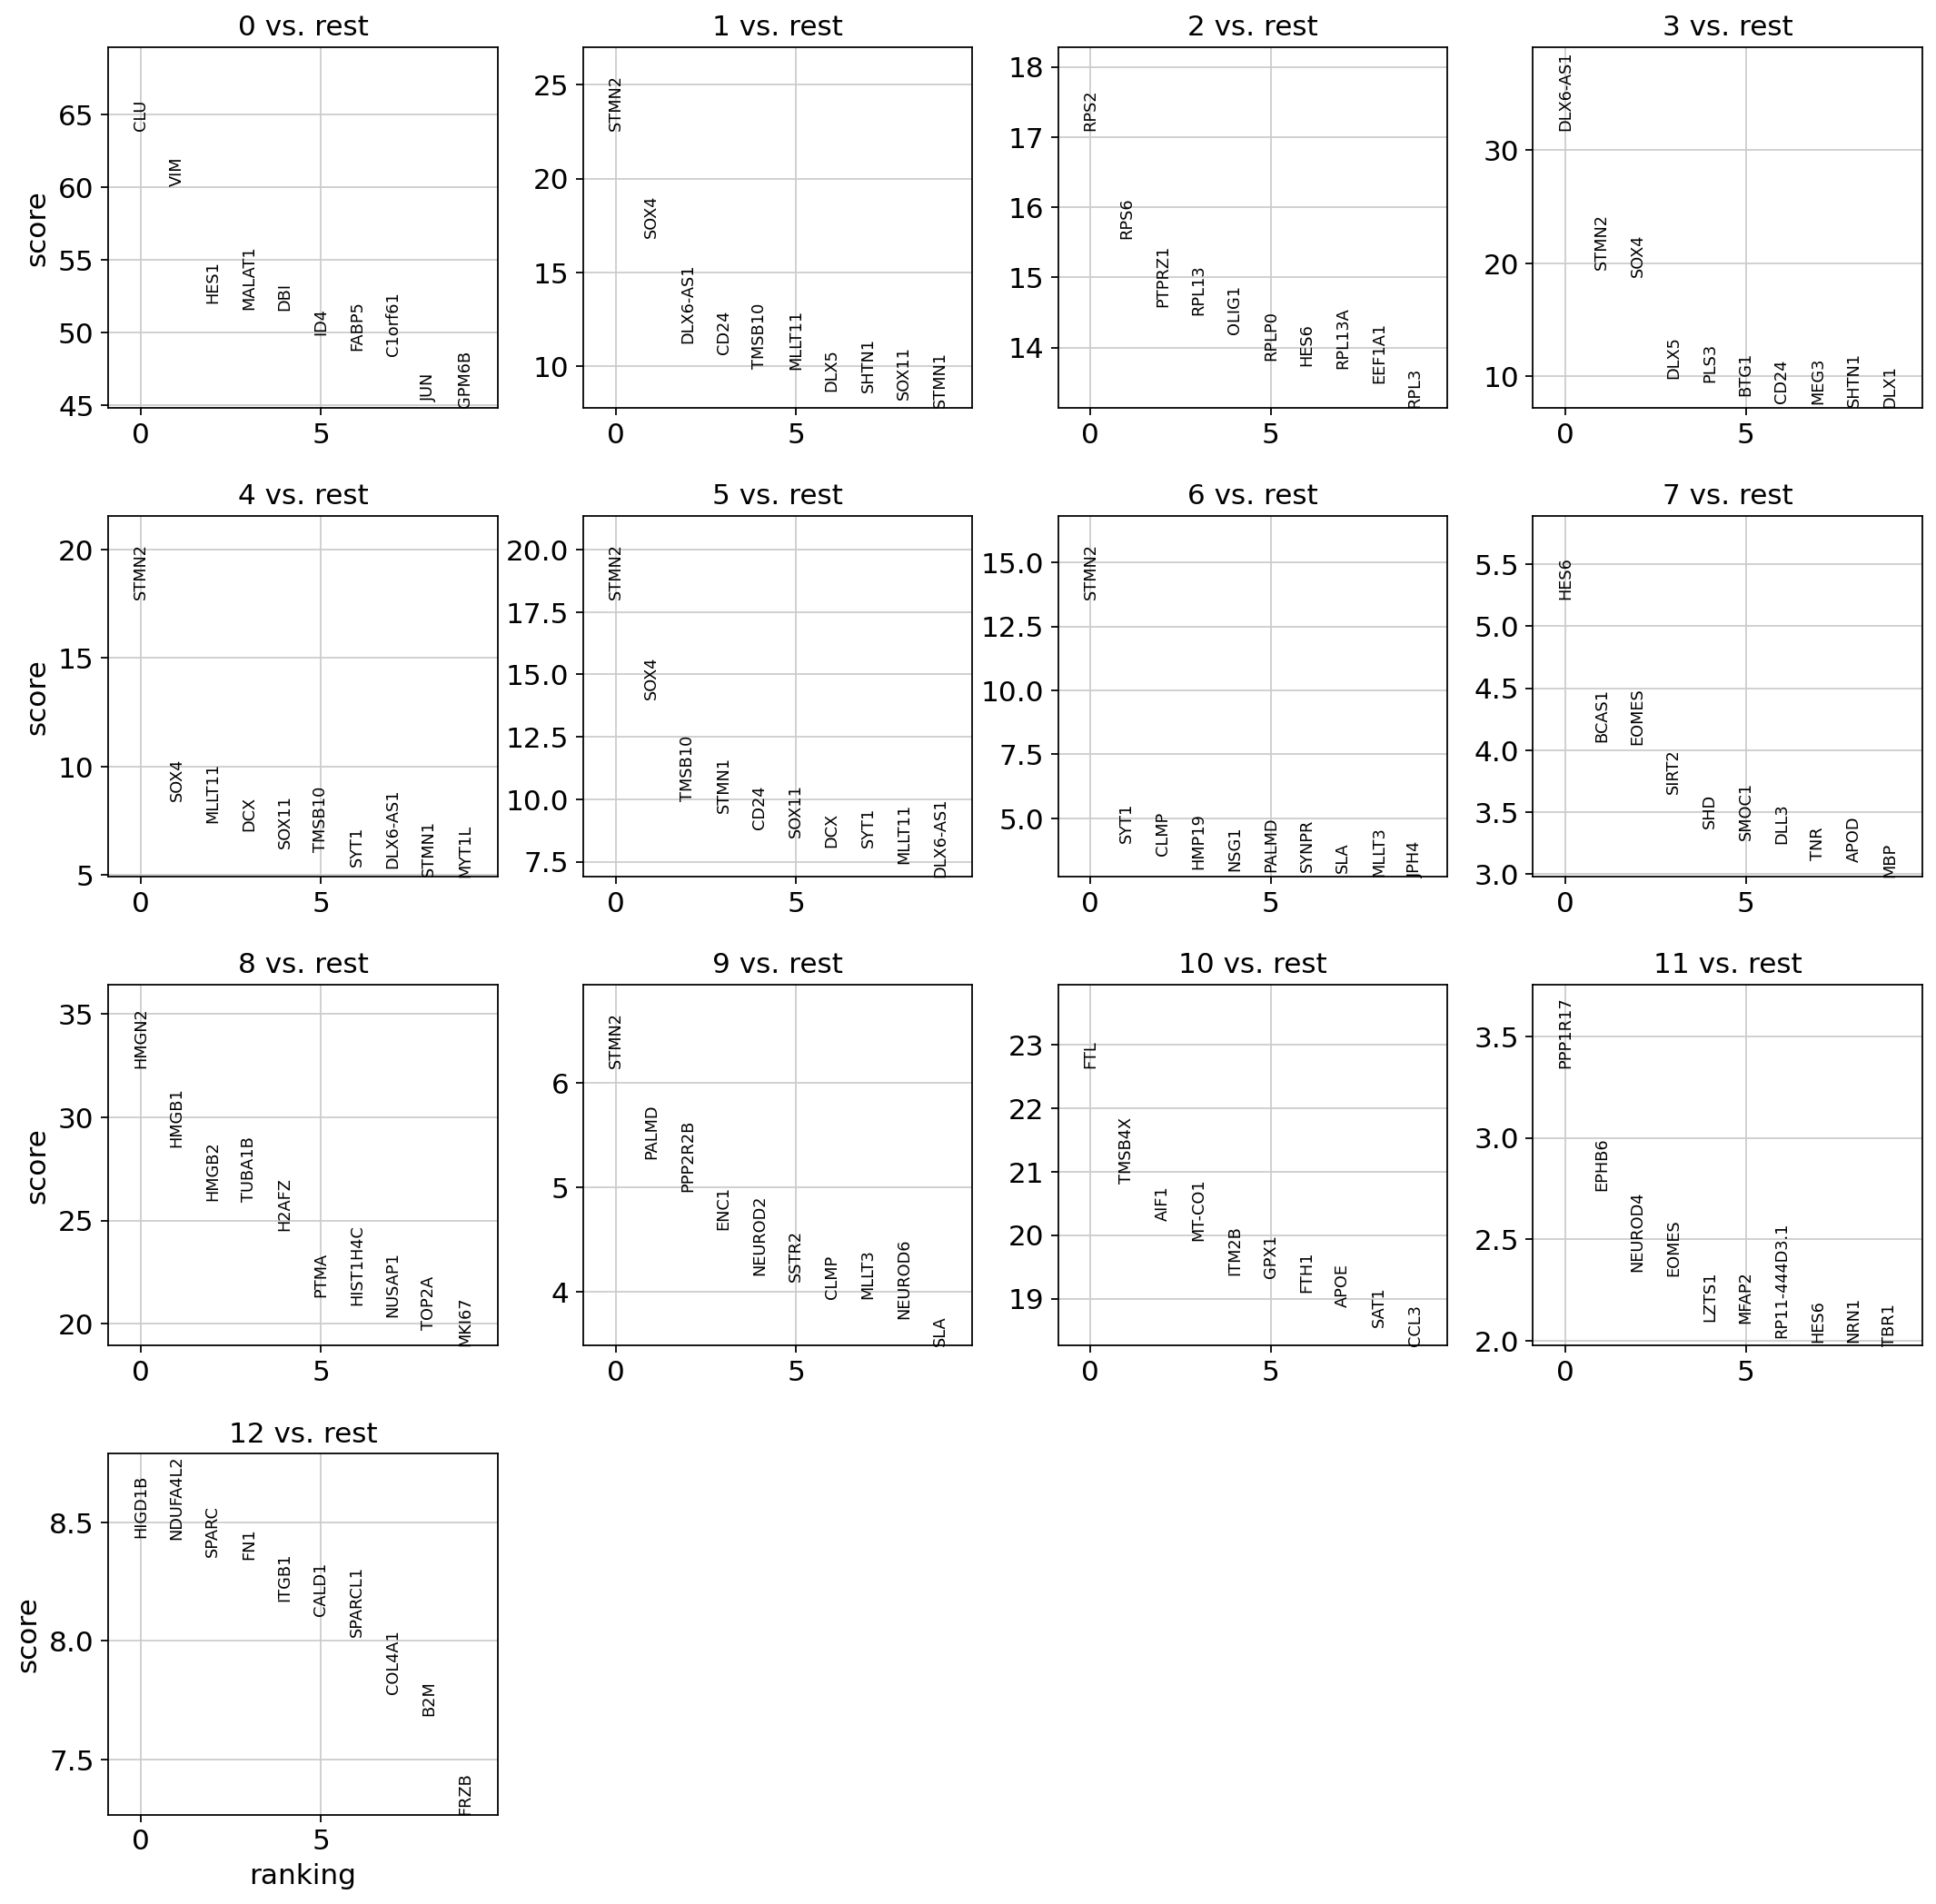

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [39]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p       1_n           1_p     2_n           2_p       3_n  \
0     CLU  0.0     STMN2  2.908451e-98    RPS2  1.596438e-58  DLX6-AS1   
1     VIM  0.0      SOX4  4.513479e-59    RPS6  2.009120e-49     STMN2   
2    HES1  0.0  DLX6-AS1  4.181735e-28  PTPRZ1  4.207703e-45      SOX4   
3  MALAT1  0.0      CD24  9.937561e-26   RPL13  1.238290e-43      DLX5   
4     DBI  0.0    TMSB10  1.895658e-22   OLIG1  1.414280e-41      PLS3   

             3_p     4_n           4_p  ...     8_n            8_p      9_n  \
0  2.772275e-148   STMN2  6.079229e-61  ...   HMGN2  2.493292e-121    STMN2   
1   2.358660e-71    SOX4  1.419163e-16  ...   HMGB1  1.062074e-104    PALMD   
2   3.792776e-67  MLLT11  3.125088e-13  ...   HMGB2   2.904551e-92  PPP2R2B   
3   1.407970e-21     DCX  4.029360e-12  ...  TUBA1B   2.949187e-92     ENC1   
4   2.380040e-20   SOX11  6.403616e-10  ...   H2AFZ   1.131261e-85  NEUROD2   

            9_p    10_n          10_p     11_n      11_p      12_n  \
0  2.436686e-09     FTL  3.655659e-62  PPP1R17  0.000976    HIGD1B   
1  2.623929e-07  TMSB4X  1.882920e-56    EPHB6  0.006679  NDUFA4L2   
2  1.179602e-06    AIF1  2.540583e-54  NEUROD4  0.020224     SPARC   
3  6.457157e-06  MT-CO1  1.467102e-53    EOMES  0.021340       FN1   
4  4.095512e-05   ITM2B  1.378535e-51    LZTS1  0.037416     ITGB1   

           12_p  
0  6.751360e-11  
1  6.986718e-11  
2  8.875828e-11  
3  9.302657e-11  
4  1.673904e-10  

[5 rows x 26 columns]

In [40]:
adata.write(results_file)

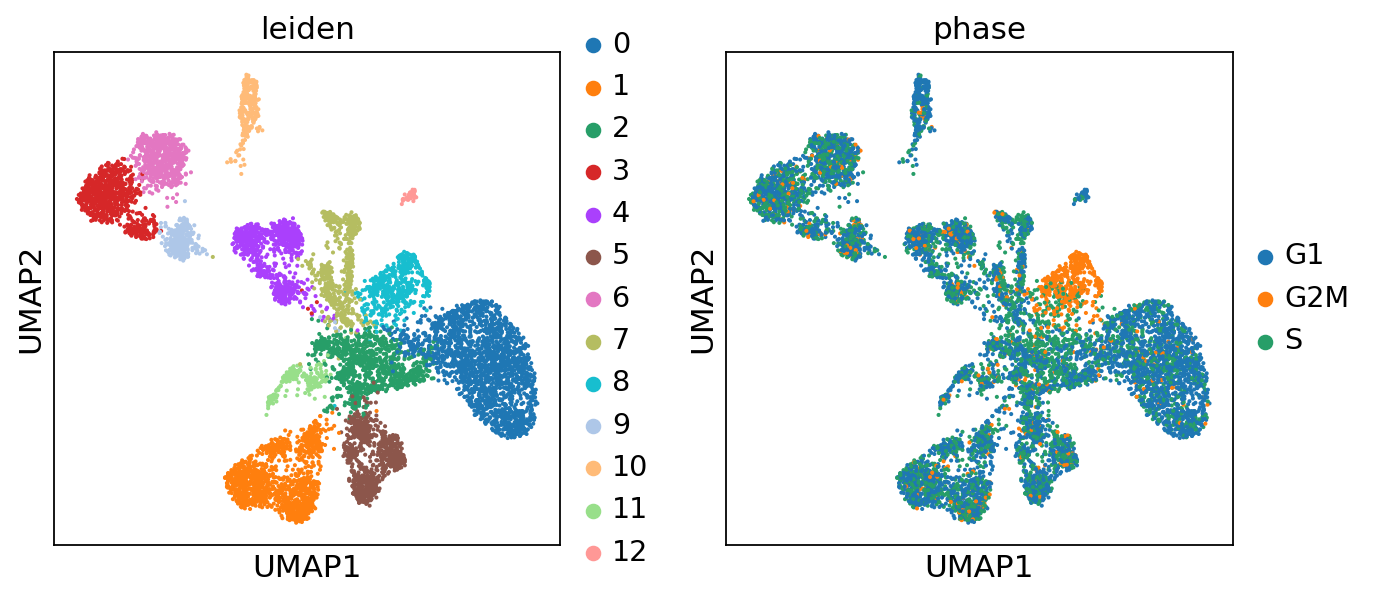

In [41]:
sc.pl.umap(adata,color=["leiden","phase"])

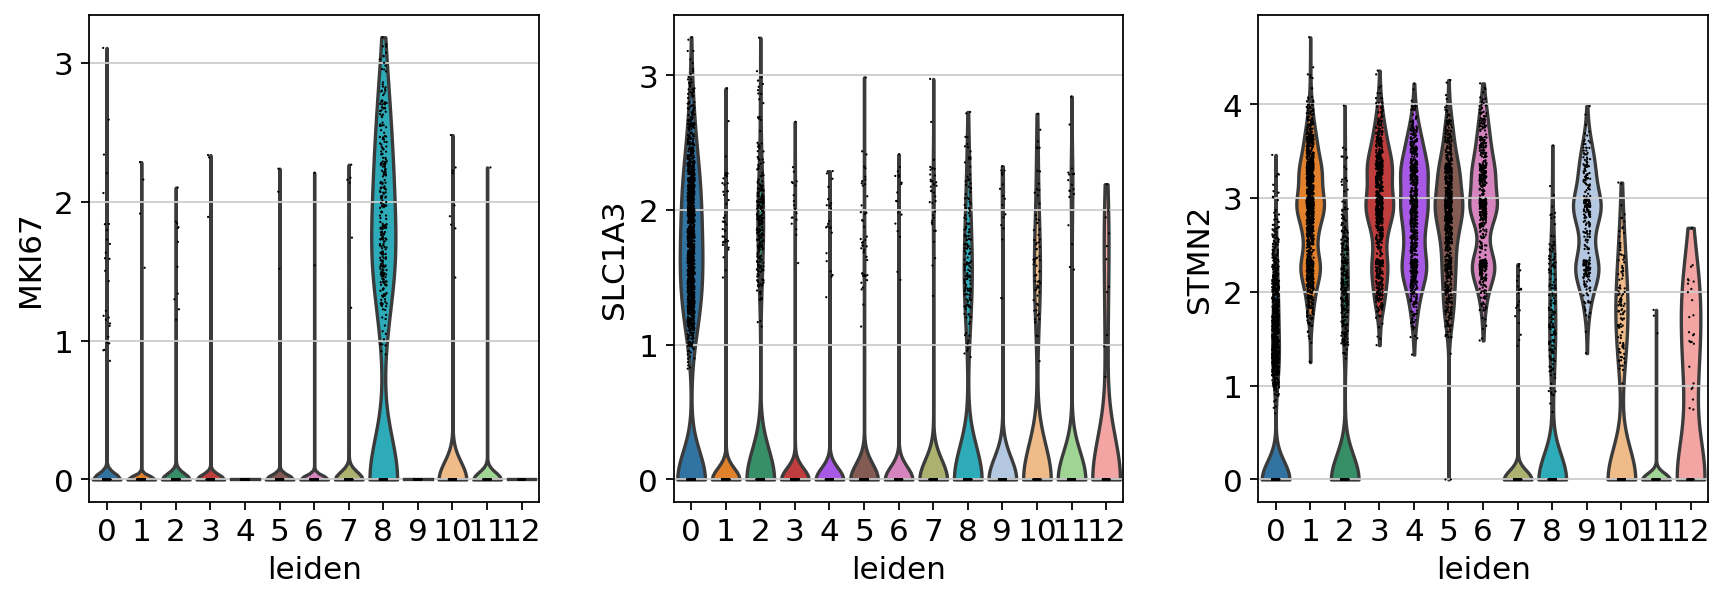

In [42]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0         1       2         3         4         5      6      7  \
0      CLU     STMN2    RPS2  DLX6-AS1     STMN2     STMN2  STMN2   HES6   
1      VIM      SOX4    RPS6     STMN2      SOX4      SOX4   SYT1  BCAS1   
2     HES1  DLX6-AS1  PTPRZ1      SOX4    MLLT11    TMSB10   CLMP  EOMES   
3   MALAT1      CD24   RPL13      DLX5       DCX     STMN1  HMP19  SIRT2   
4      DBI    TMSB10   OLIG1      PLS3     SOX11      CD24   NSG1    SHD   
5      ID4    MLLT11   RPLP0      BTG1    TMSB10     SOX11  PALMD  SMOC1   
6    FABP5      DLX5    HES6      CD24      SYT1       DCX  SYNPR   DLL3   
7  C1orf61     SHTN1  RPL13A      MEG3  DLX6-AS1      SYT1    SLA    TNR   
8      JUN     SOX11  EEF1A1     SHTN1     STMN1    MLLT11  MLLT3   APOD   
9    GPM6B     STMN1    RPL3      DLX1     MYT1L  DLX6-AS1   JPH4    MBP   

          8        9      10            11        12  
0     HMGN2    STMN2     FTL       PPP1R17    HIGD1B  
1     HMGB1    PALMD  TMSB4X         EPHB6  NDUFA4L2  
2     HMGB2  PPP2R2B    AIF1       NEUROD4     SPARC  
3    TUBA1B     ENC1  MT-CO1         EOMES       FN1  
4     H2AFZ  NEUROD2   ITM2B         LZTS1     ITGB1  
5      PTMA    SSTR2    GPX1         MFAP2     CALD1  
6  HIST1H4C     CLMP    FTH1  RP11-444D3.1   SPARCL1  
7    NUSAP1    MLLT3    APOE          HES6    COL4A1  
8     TOP2A  NEUROD6    SAT1          NRN1       B2M  
9     MKI67      SLA    CCL3          TBR1      FRZB

In [44]:
marker_genes = ['leiden','CLU','STMN2', 'RPS2', 'DLX5', 'MLLT11', 'TMSB10', 'SYT1', 'BCAS1', 'HMGN2', 'PALMD', 'FTL', 'AIF1', 'EPHB6', 'SPARC' ]

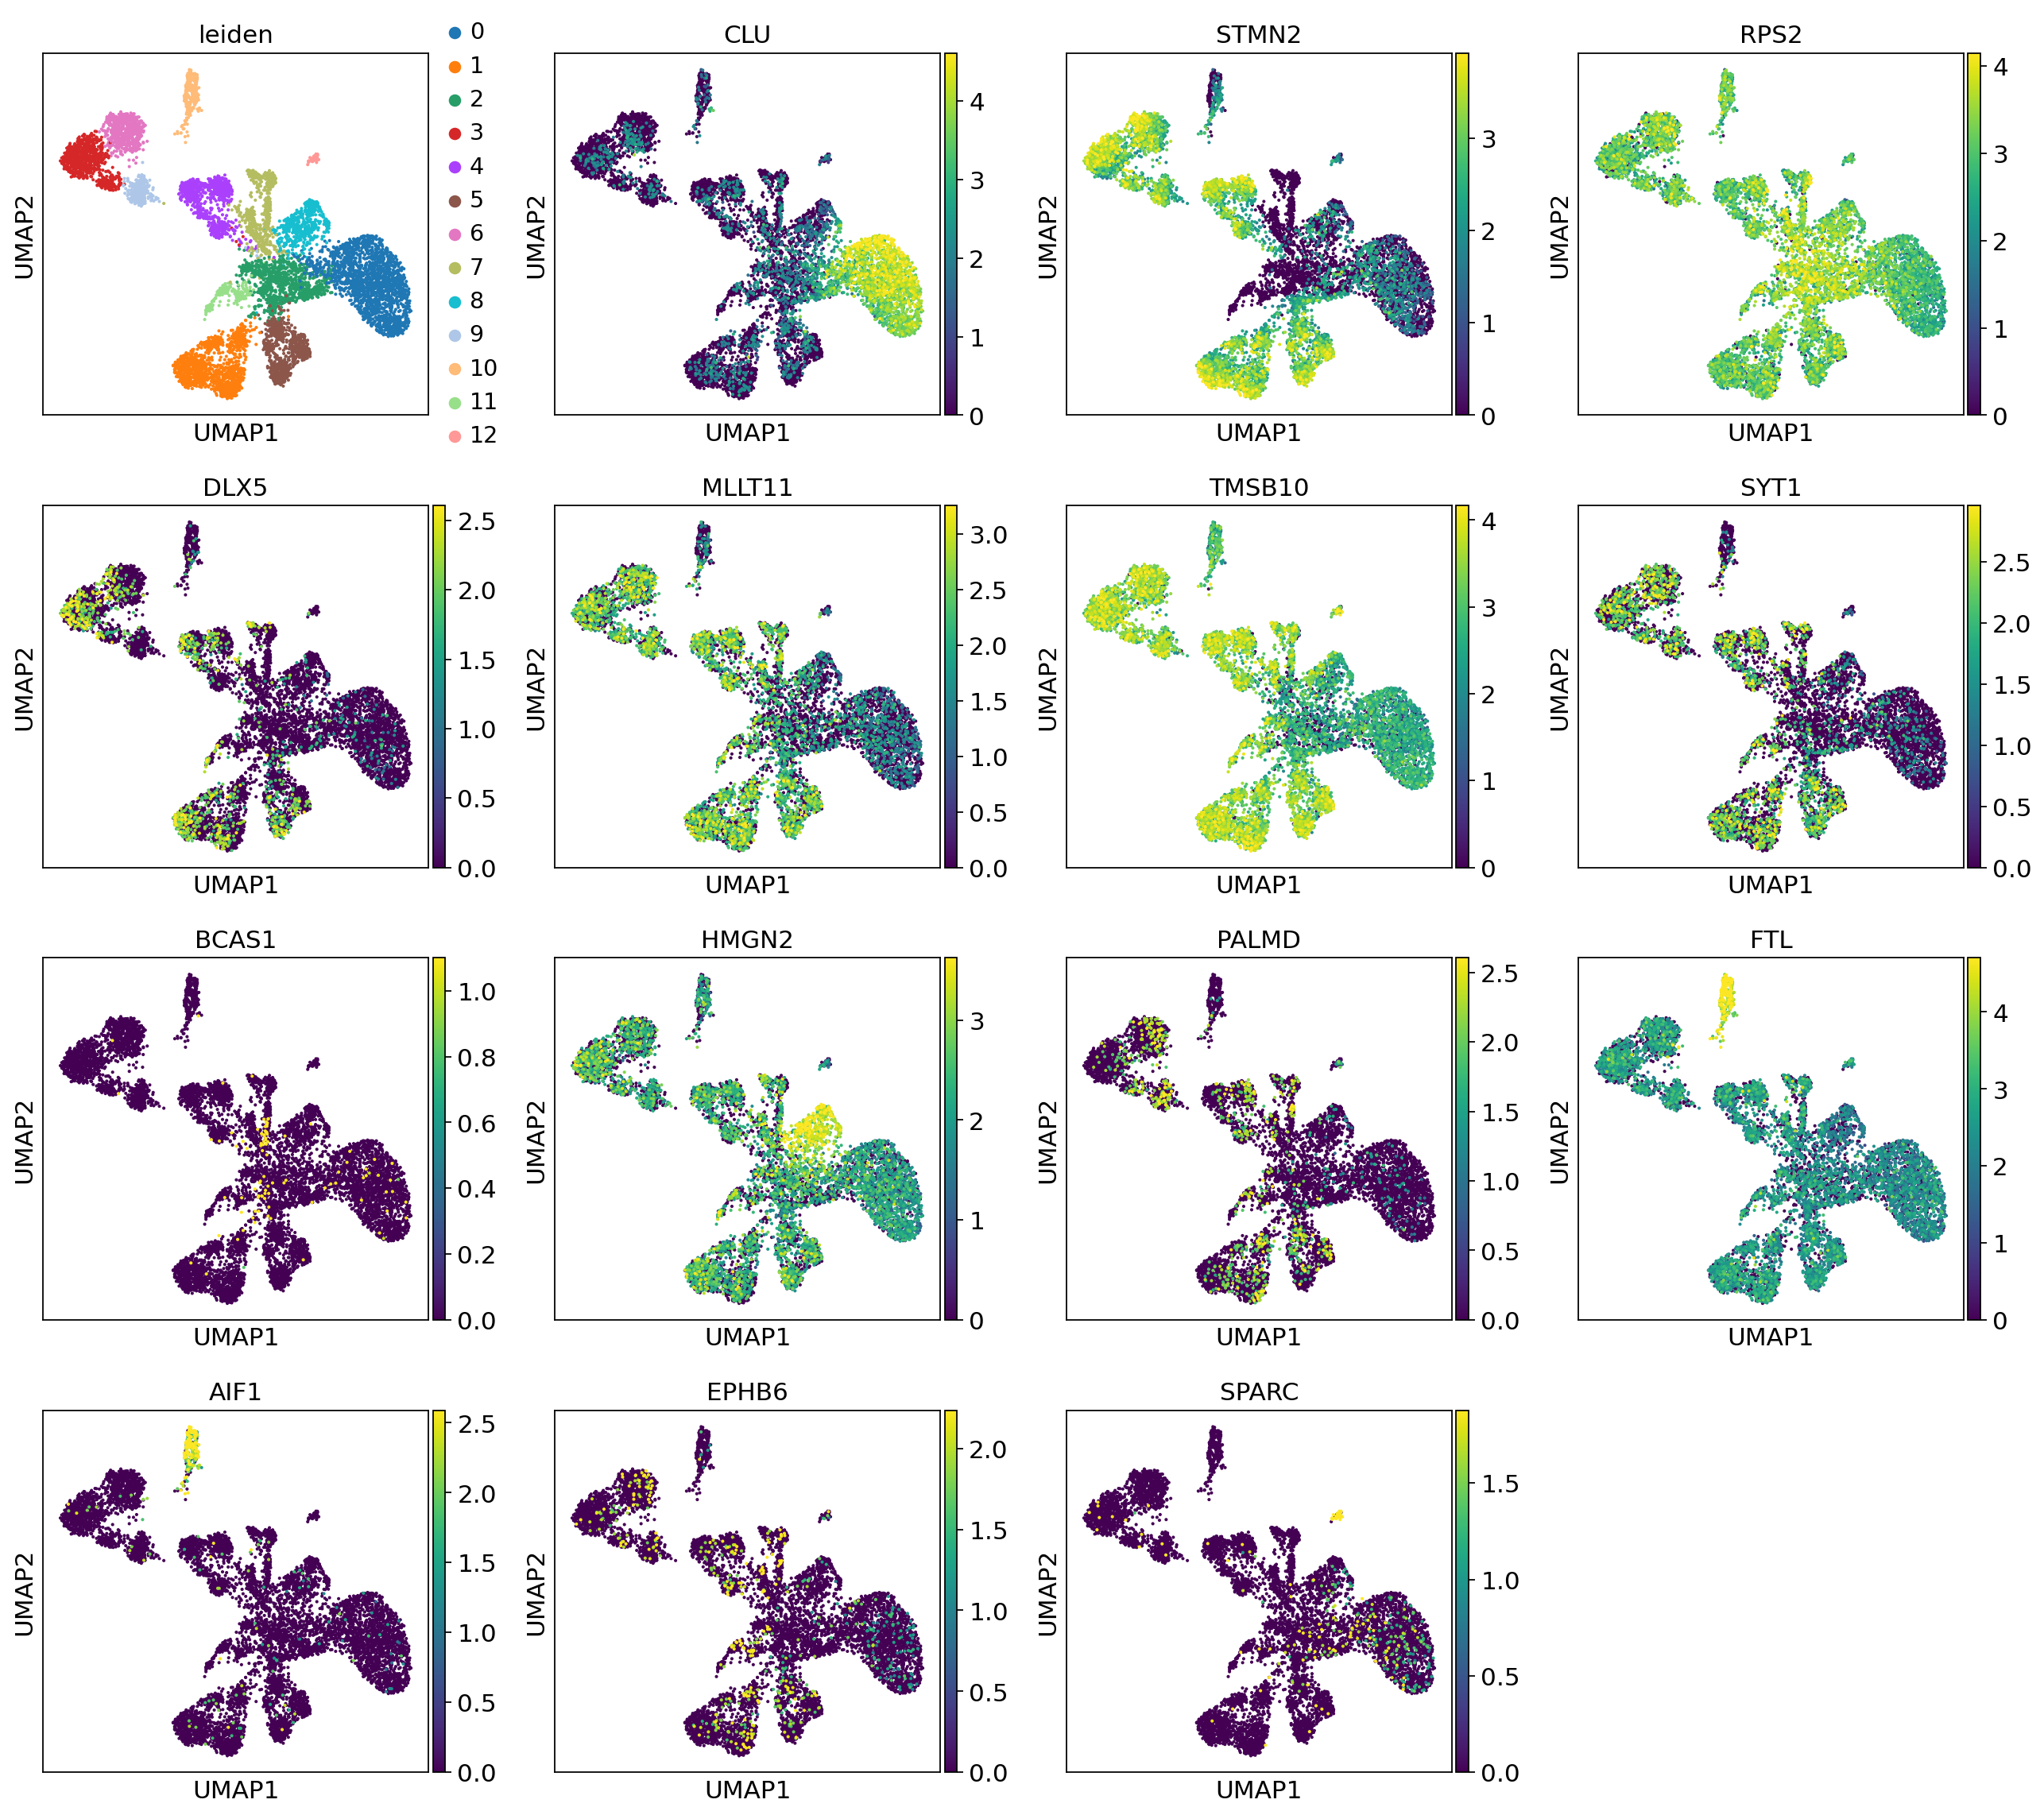

In [45]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [46]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99514735 0.99342173 0.9886509  0.9833598  0.978084
     0.9718484  0.96701646 0.9661646  0.96447617 0.96279293 0.95712984
     0.95392096 0.95139515 0.9440032 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


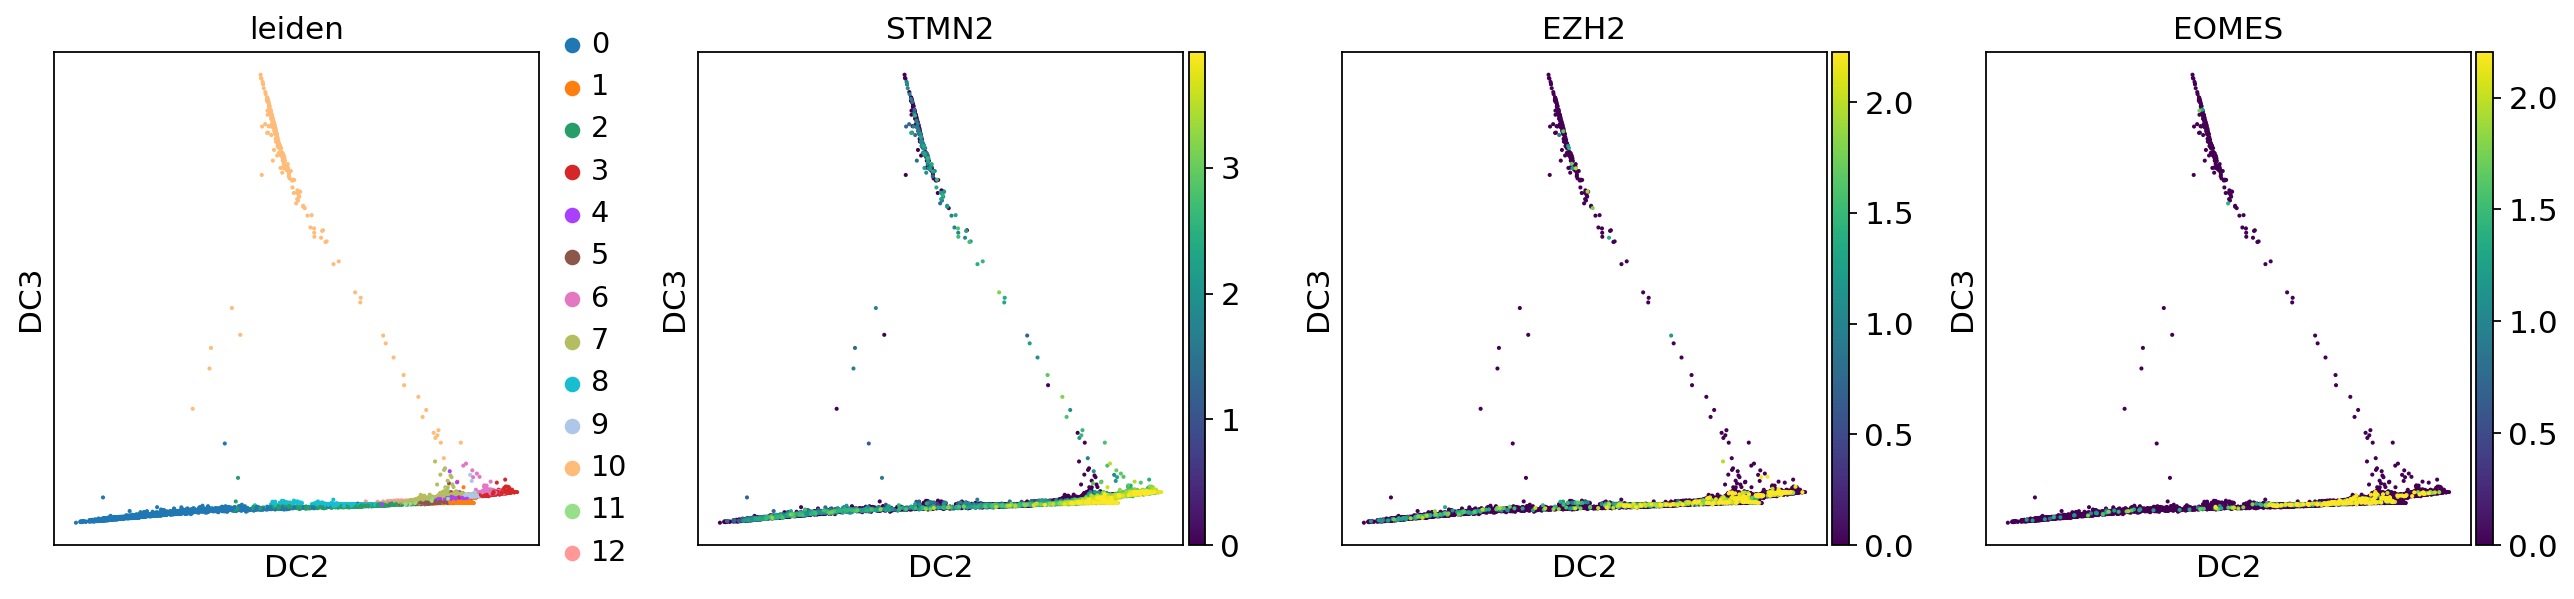

In [47]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','EZH2', 'EOMES'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [48]:
#adata_check = adata[~adata.obs.leiden.isin(['7'])].copy()

In [49]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: astrocytes, pericyte, microglia, etc.


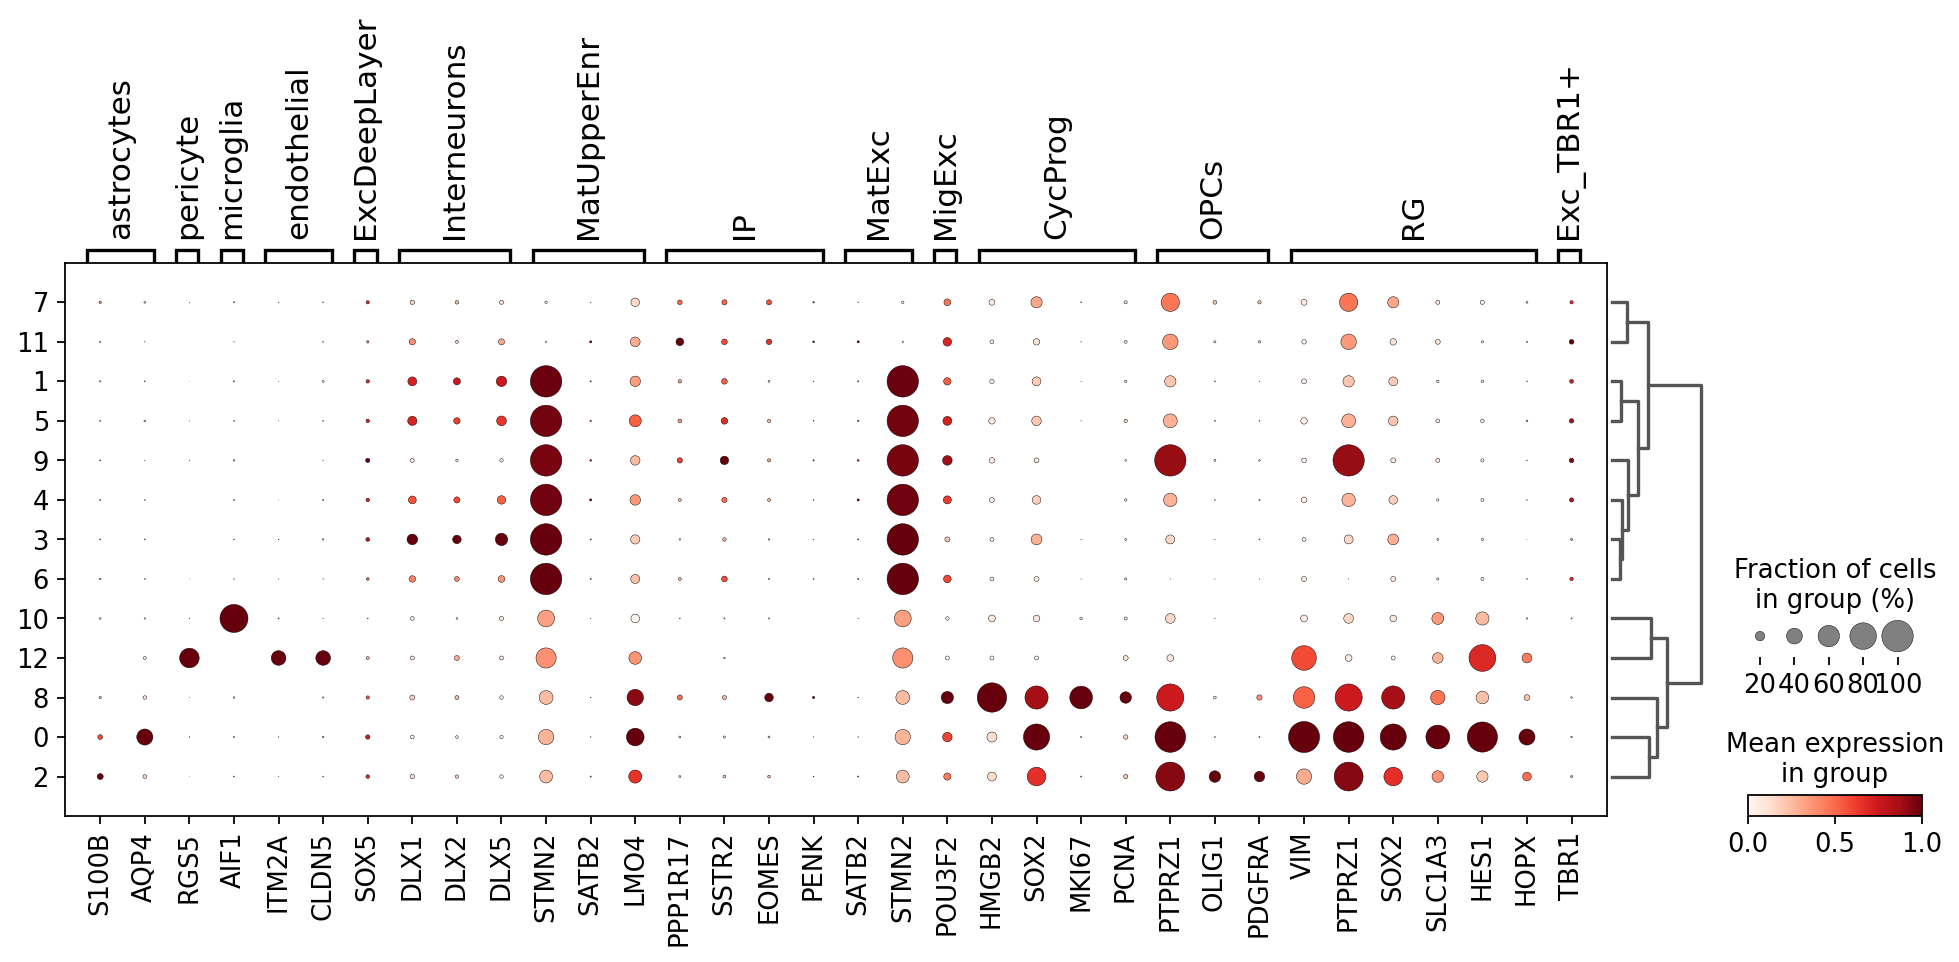

In [50]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_TBR1+' : ['TBR1']
}

sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [51]:
# GENERAL ONE
cluster2annotation = {
     "0": "RG/astro", "1": "Neu", "2":"RG", "3": "Neu",
    "4": "Neu", "5" : "Neu", "6": "Neu", "7": "IP", "8": "Neu",
    "9": "Neu", "10" : "microglia", "11": "IP", "12": "endothelial"
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [52]:
# SPECIFIC 

cluster2annotation = {
     "0": "oRG/astro", "1": "Mat","2":"vRG", "3": "Interneuron",
    "4": "Mat", "5" : "Mat", "6": "Mat", "7": "IP", "8": "MigExc",
    "9": "MigExc", "10" : "microglia", "11": "IP", "12": "endo"
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [53]:
new_cluster_names = [
    '0/oRG/astro', '1/Mat',
    '2/vRG', '3/Interneuron',
    '4/Mat','5/Mat',
    '6/Mat', '7/IP', '8/MigExc',
    '9/MigExc', '10/microglia', '11/IP',
    '12/endo']
adata.rename_categories('leiden', new_cluster_names)

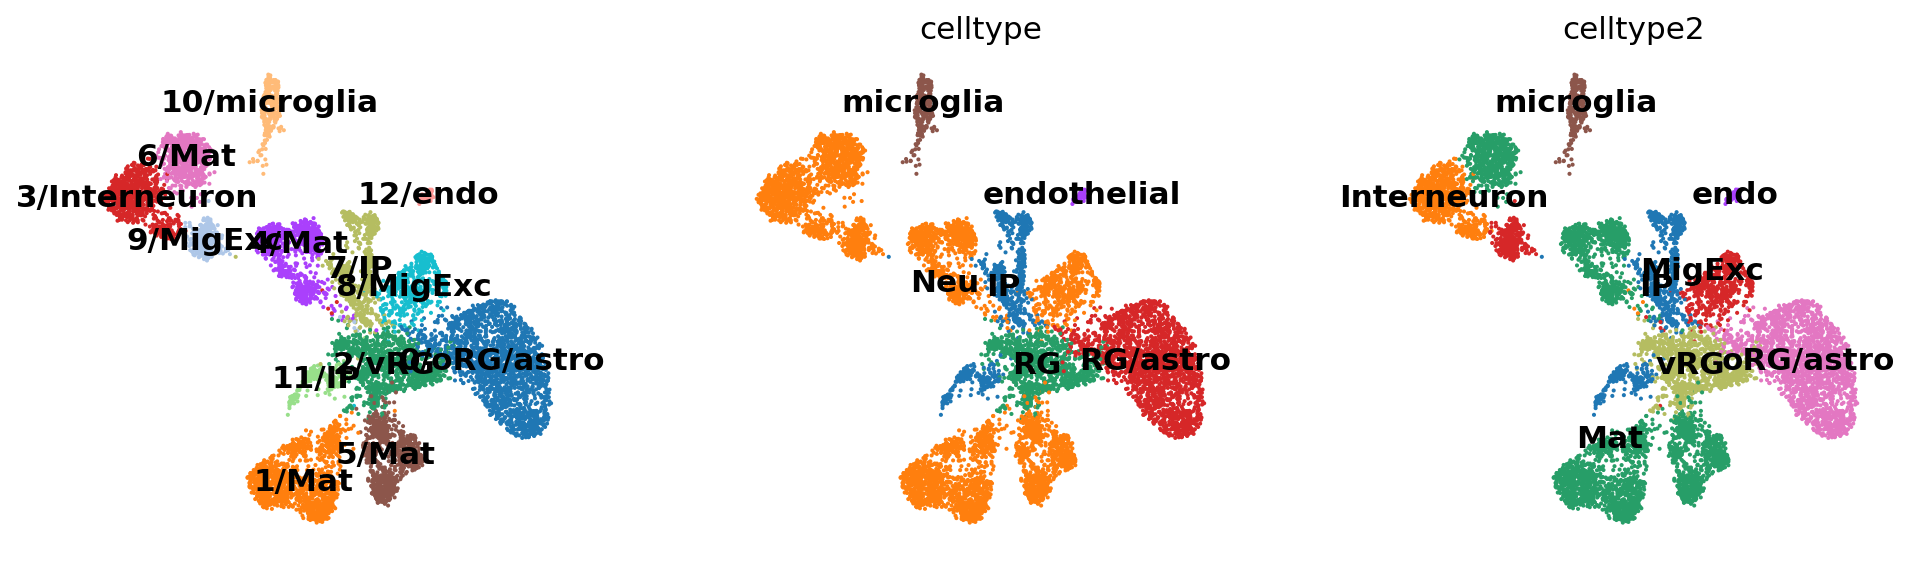

In [54]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

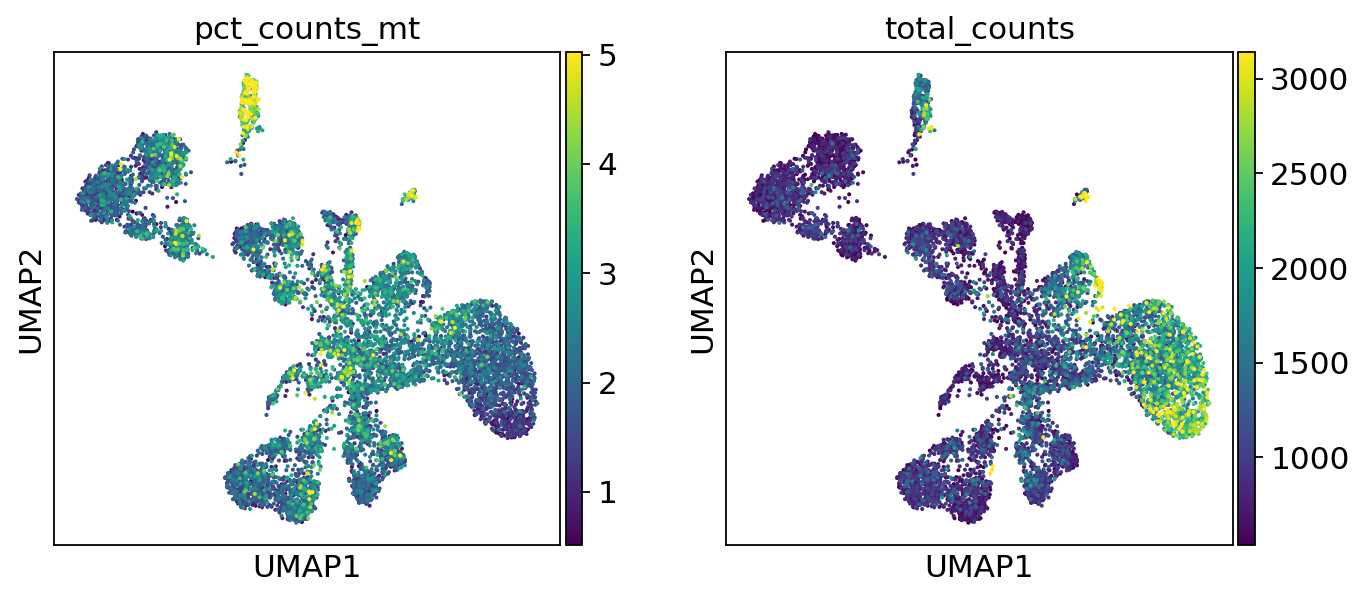

In [55]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [56]:
sc.tl.dendrogram(adata,"leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [57]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99514735 0.99342173 0.9886509  0.9833598  0.978084
     0.9718484  0.96701646 0.9661646  0.96447617 0.96279293 0.95712984
     0.95392096 0.95139515 0.9440032 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [58]:
adata.obs.leiden.value_counts()

0/oRG/astro      1878
1/Mat            1275
2/vRG             938
3/Interneuron     777
4/Mat             775
5/Mat             756
6/Mat             622
7/IP              588
8/MigExc          460
9/MigExc          276
10/microglia      248
11/IP             215
12/endo            47
Name: leiden, dtype: int64

In [59]:
adata_check = adata[~adata.obs.celltype.isin(['microglia', 'endothelial'])].copy()

In [60]:
sc.tl.diffmap(adata_check)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9954728  0.9891182  0.9837379  0.9785019  0.97216946
     0.9671194  0.9650594  0.96377796 0.95803577 0.95407933 0.95152986
     0.9444662  0.9411299  0.9298645 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


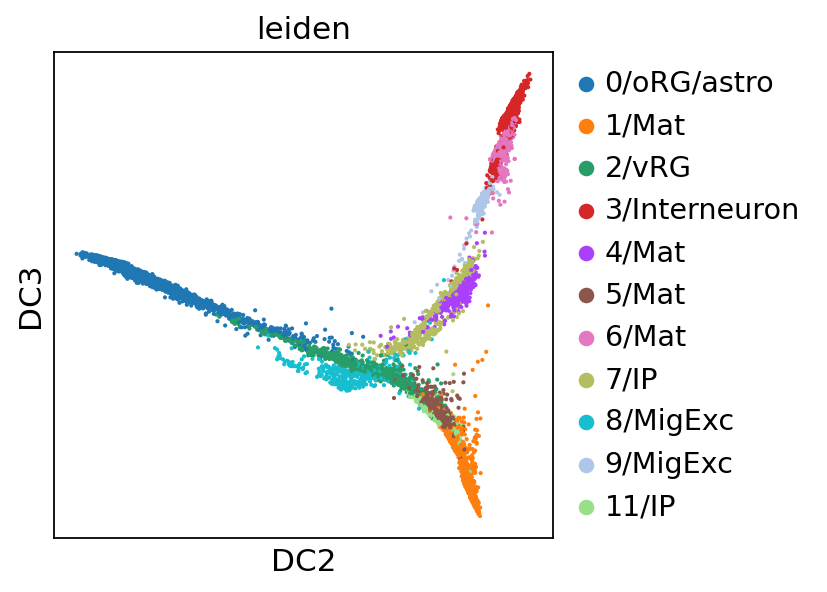

In [61]:
sc.pl.diffmap(adata_check,color="leiden",dimensions=(1,2))

In [62]:
adata.obs.leiden

AAACCTGAGAGTAATC-1    3/Interneuron
AAACCTGAGCTCTCGG-1      0/oRG/astro
AAACCTGAGTCGAGTG-1         8/MigExc
AAACCTGCACATTAGC-1            2/vRG
AAACCTGCACGTTGGC-1     10/microglia
                          ...      
TTTGTCATCATACGGT-1      0/oRG/astro
TTTGTCATCATCTGCC-1            2/vRG
TTTGTCATCCATGAGT-1    3/Interneuron
TTTGTCATCCGCATCT-1         8/MigExc
TTTGTCATCTGCCAGG-1            1/Mat
Name: leiden, Length: 8855, dtype: category
Categories (13, object): ['0/oRG/astro', '1/Mat', '2/vRG', '3/Interneuron', ..., '9/MigExc', '10/microglia', '11/IP', '12/endo']

In [64]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW25_05_20240216_v1.h5ad")

In [3]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW25_05_20240216_v1.h5ad")

In [4]:
adata.obs['stage'] = 'GW25'

In [5]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/GW25_05_20240216_v1.h5ad')